In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from preprocessing_helpers import organize_csv_files_by_dir, process_files

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

from analysis_helpers import *

# Cleaning (Preprocessing) the data

## 0. Save the references by experiment (if mixed on another folder)

In [6]:
source_directory = "../../performance_evaluation/references"    
destination_directory = "../../interviews_corrected/0_raw"    

organize_csv_files_by_dir(source_directory, destination_directory)

../../performance_evaluation/references\ID 05.csv
Copied ID 05.csv to ../../interviews_corrected/0_raw\OBE1
../../performance_evaluation/references\Id 08.csv
Copied Id 08.csv to ../../interviews_corrected/0_raw\OBE1
../../performance_evaluation/references\Id 13.csv
Copied Id 13.csv to ../../interviews_corrected/0_raw\OBE1
../../performance_evaluation/references\Id 13b.csv
Copied Id 13b.csv to ../../interviews_corrected/0_raw\OBE1
../../performance_evaluation/references\Id 14.csv
Copied Id 14.csv to ../../interviews_corrected/0_raw\OBE1
../../performance_evaluation/references\Id 15.csv
Copied Id 15.csv to ../../interviews_corrected/0_raw\OBE1
../../performance_evaluation/references\Id 16.csv
Copied Id 16.csv to ../../interviews_corrected/0_raw\OBE1
../../performance_evaluation/references\Id 17.csv
Copied Id 17.csv to ../../interviews_corrected/0_raw\OBE1
../../performance_evaluation/references\Id 18.csv
Copied Id 18.csv to ../../interviews_corrected/0_raw\OBE1
../../performance_evaluati

## 1. Remove fillers, repetitions

In [ ]:
source_directory = "../../interviews_corrected/0_raw" 
destination_directory = "../../interviews_corrected/1_cleaned"    

# List of common filler words to remove
filler_words = ["uh", "huh", "um", "hmm", "Mm"]

process_files(source_directory, destination_directory, filler_words)


## 2. Predict assignment of Speaker Role if not done manually
- Achieve 100 % accuracy, on this subset of interviews.

- Work pretty well, on *normal* audio interviews, might be incorrect on "0 : No interview (eg. Set-up)" see **structured_data_manual.xlsx** (even if in this subset it  was correctly predicted)

In [ ]:
source_directory = "../../interviews_corrected/1_cleaned"    
destination_directory = "../../interviews_corrected/2_cleaned_role" 

process_files(source_directory, destination_directory, roles=True)

File 'S209-2.csv': Couldn't accurately predict the most probable participant. Define the mosts probable interviewers and select by default the participant as a fallback.


In [10]:
"""import pandas as pd
from analysis_helpers import assign_roles

file = "../../interviews_corrected/1_cleaned/OBE2/S208-1.csv"
df = pd.read_csv(file)

roles, f = assign_roles(df)
f"""

'import pandas as pd\nfrom analysis_helpers import assign_roles\n\nfile = "../../interviews_corrected/1_cleaned/OBE2/S208-1.csv"\ndf = pd.read_csv(file)\n\nroles, f = assign_roles(df)\nf'

## 3. Manual check to verify the role assignment & cut unrelated parts of the interview (Setup, etc.)

## 4.Text Format :)

In [3]:
source_directory = "../../interviews_corrected/3_manual_check"    
destination_directory = "../../interviews_corrected/4_text" 

process_files(source_directory, destination_directory, text_format=True)

## 5. Conditions Info

In [14]:
source_directory = "../../interviews_corrected/3_manual_check"  
destination_directory = "../../interviews_corrected/5_conditions_B"

condition_info = pd.read_excel("../../interviews_corrected/structured_data_manual.xlsx")

process_files(source_directory, destination_directory, conditions=condition_info)

# Condition Distribution by experiments & Id

In [78]:
condition_info = pd.read_excel("../../interviews_corrected/structured_data_manual.xlsx")

In [79]:
id_summary = condition_info.groupby(['Experiment', "Id"]).agg({
    'File Name': 'count',
    'Condition': lambda x: list(x),
    'Order Condition': lambda x: list(set(x))
}).rename(columns={'File Name': 'Interview_Count'})

id_summary.to_csv("summary_interview.csv")

In [82]:
# 1. Experiment summary including total interview count and participant count per experiment
experiment_summary = condition_info.groupby(['Experiment']).agg({
    'File Name': 'count',
    'Id': lambda x: len(set(x)),
}).rename(columns={'File Name': 'Interview_Count', 'Id': 'ID_Count'}).reset_index()

# 2. Number of participants with a given order of condition
order_condition_summary = condition_info.groupby(['Experiment', 'Order Condition']).agg({
    'Id': lambda x: len(set(x))
}).rename(columns={'Id': 'ID_Count_Per_Order'}).reset_index()

# 3. Count of participants with at least one 'C' and one 'I' per Order Condition
def has_C_and_I(conditions):
    unique_conditions = set(conditions)
    return 'C' in unique_conditions and 'I' in unique_conditions

# Compute whether each participant has both 'C' and 'I' and add Order Condition
participants_with_C_and_I_per_order = condition_info.groupby(['Experiment', 'Order Condition', 'Id'])['Condition'] \
    .apply(lambda x: has_C_and_I(x)).reset_index()

# Sum the participants with both 'C' and 'I' per Order Condition
participants_with_C_and_I_per_order = participants_with_C_and_I_per_order[participants_with_C_and_I_per_order['Condition'] == True] \
    .groupby(['Experiment', 'Order Condition']).size().rename("Participants_with_C_and_I").reset_index()

# 4. Count of participants with Condition equal to '1' per Experiment and Order Condition
condition_1_count_per_order = condition_info[condition_info['Condition'] == 1].groupby(['Experiment', 'Order Condition'])['Id'] \
    .nunique().rename("ID with only 1 interview").reset_index()

# Set 'Experiment' as the index in experiment_summary to match the joins
experiment_summary.set_index('Experiment', inplace=True)

# Join summaries
experiment_summary = experiment_summary.join(order_condition_summary.set_index('Experiment'), on='Experiment')
experiment_summary = experiment_summary.join(participants_with_C_and_I_per_order.set_index(['Experiment', 'Order Condition']), 
                                             on=['Experiment', 'Order Condition'])
experiment_summary = experiment_summary.join(condition_1_count_per_order.set_index(['Experiment', 'Order Condition']), 
                                             on=['Experiment', 'Order Condition'])

# Fill any NaN values in Participants_with_C_and_I and "ID with only 1 interview" with 0
experiment_summary['Participants_with_C_and_I'] = experiment_summary['Participants_with_C_and_I'].fillna(0).astype(int)
experiment_summary['ID with only 1 interview'] = experiment_summary['ID with only 1 interview'].fillna(0).astype(int)

experiment_summary.reset_index(inplace=True)  # Reset index for easy viewing

# Save to CSV
experiment_summary.to_csv("experiment_summary.csv", index=False)

experiment_summary


Experiment  Interview_Count  ID_Count Order Condition  ID_Count_Per_Order  \
0  Compassion               10         8              CI                   3   
1  Compassion               10         8              IC                   4   
2  Compassion               10         8         Unknown                   1   
3        OBE1               18        14         Unknown                  14   
4        OBE2               54        26              CI                  14   
5        OBE2               54        26              IC                  12   

   Participants_with_C_and_I  ID with only 1 interview  
0                          0                         2  
1                          2                         2  
2                          0                         1  
3                          0                        10  
4                         11                         2  
5                          9                         3

# Analysis

In [15]:
directory = '../../interviews_corrected/5_conditions_B/**/' 

combined_df = load_and_combine_csv(directory)
combined_df = standardize_data(combined_df)
combined_df = calculate_word_char_counts(combined_df)

combined_df.to_csv("combined_data.csv", index=False)

Found 82 CSV files.
Standardized speaker labels.
Normalized text in 'Content' column.
Calculated 'Word_Count' and 'Character_Count' for each response.


In [16]:
print(combined_df["Condition"].unique())
# Drop the rows with missing values and equal to 0 for the column condition
#combined_df = combined_df[combined_df["Condition"] != "Unknown"]
combined_df = combined_df[combined_df["Condition"] != 0]
print(combined_df["Condition"].unique())

[1 'C' 'I' 0]
[1 'C' 'I']


In [18]:
# If only want to focus on participant speaker
combined_df_participant = combined_df[combined_df["Speaker"] == "Participant"]

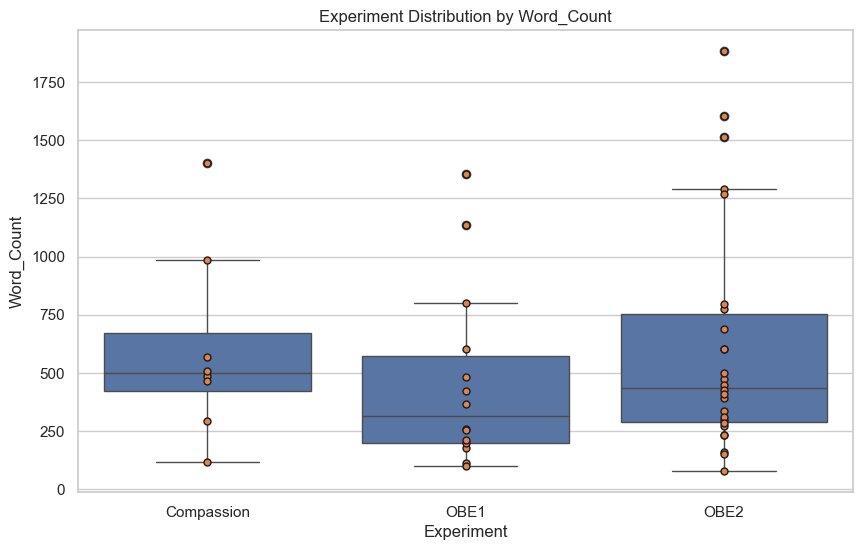

In [11]:
stripplot(aggregate_counts(combined_df_participant,["Experiment","Id"]), 'Experiment', 'Word_Count')

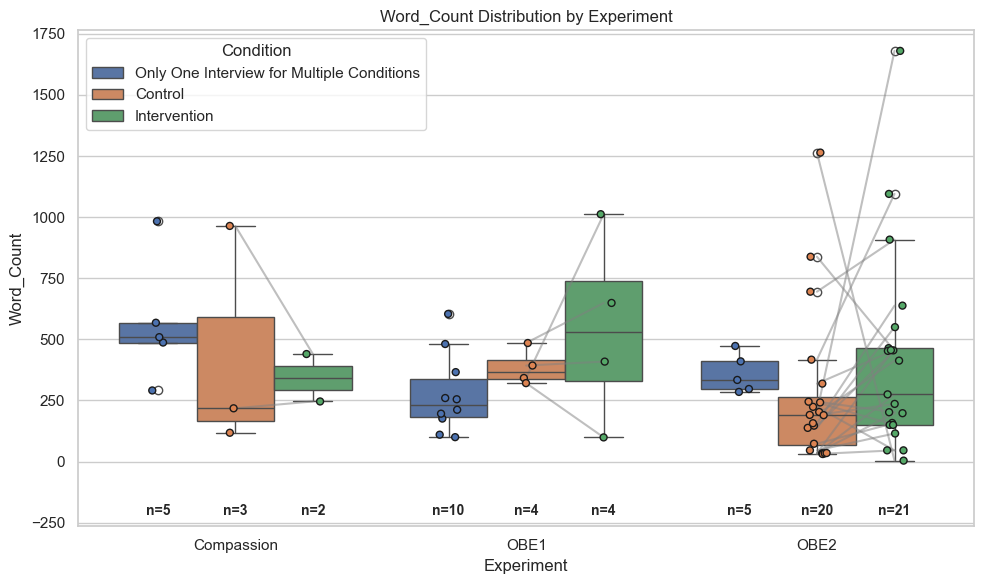

In [19]:
stripplot_with_counts(aggregate_counts(combined_df_participant, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word_Count', 'Condition', id_column="Id", file_name="stripplot_word_count_id_random.png", legend_labels=["Only One Interview for Multiple Conditions","Control","Intervention"])

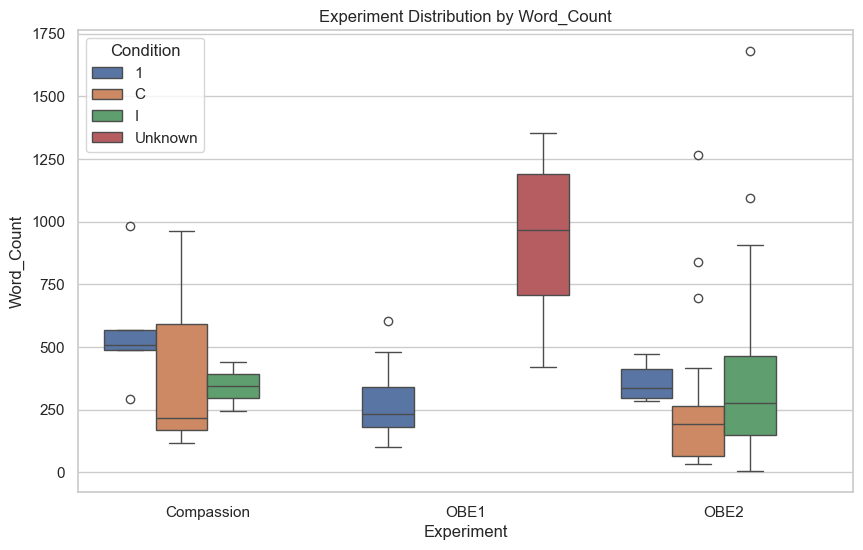

In [32]:
# Group by Id instead of File Name because the same participant can have the same condition in different interviews
box_plot(aggregate_counts(combined_df_participant, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word_Count', 'Condition')

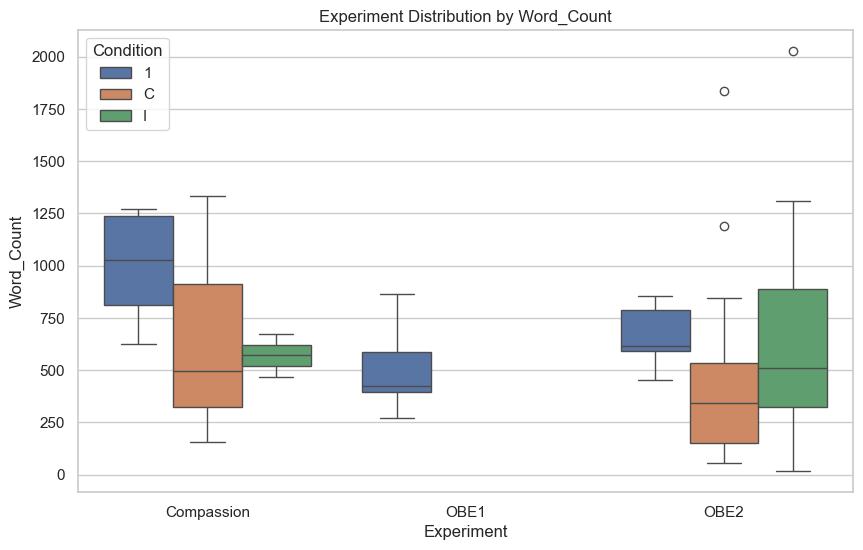

In [5]:
# Group by Id instead of File Name because the same participant can have the same condition in different interviews
box_plot(aggregate_counts(combined_df, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word_Count', 'Condition')

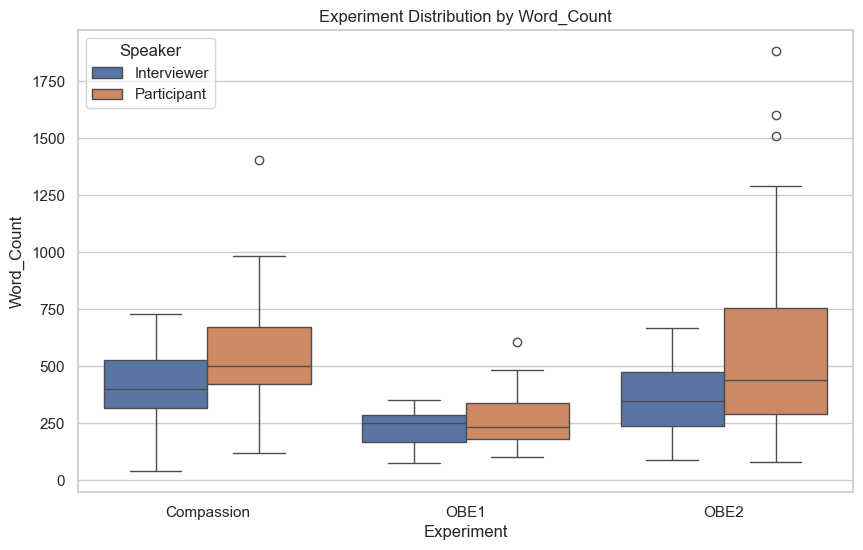

In [6]:
box_plot(aggregate_counts(combined_df, ['Experiment', "Id", 'Speaker']), 'Experiment', 'Word_Count', 'Speaker')

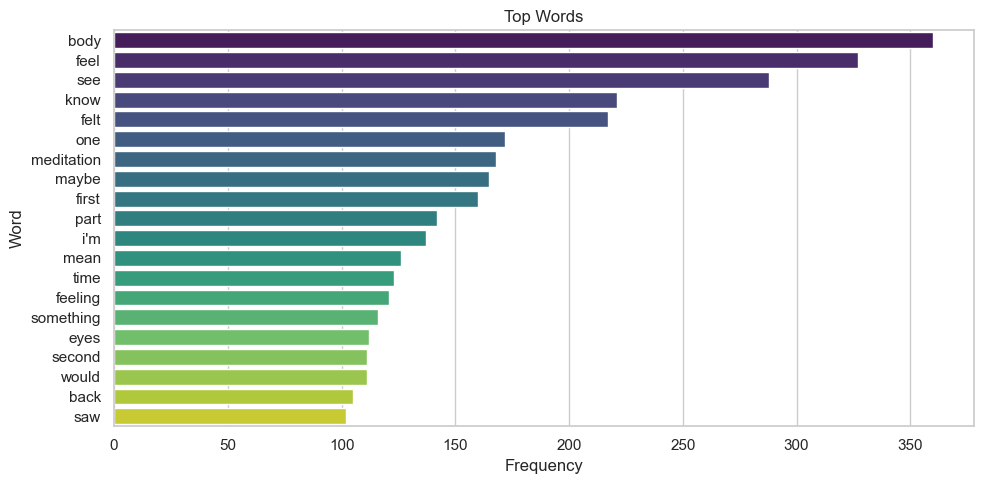

In [7]:
extra_words_to_exclude = ["yeah", "like","okay" ,"really", "it", "yes","could","kind","bit","think","that's"] 
word_frequency_plot(combined_df, extra_stopwords=extra_words_to_exclude)

In [8]:
word_frequency_plot(combined_df, groupby_column=["Experiment", "Condition"], extra_stopwords=extra_words_to_exclude)

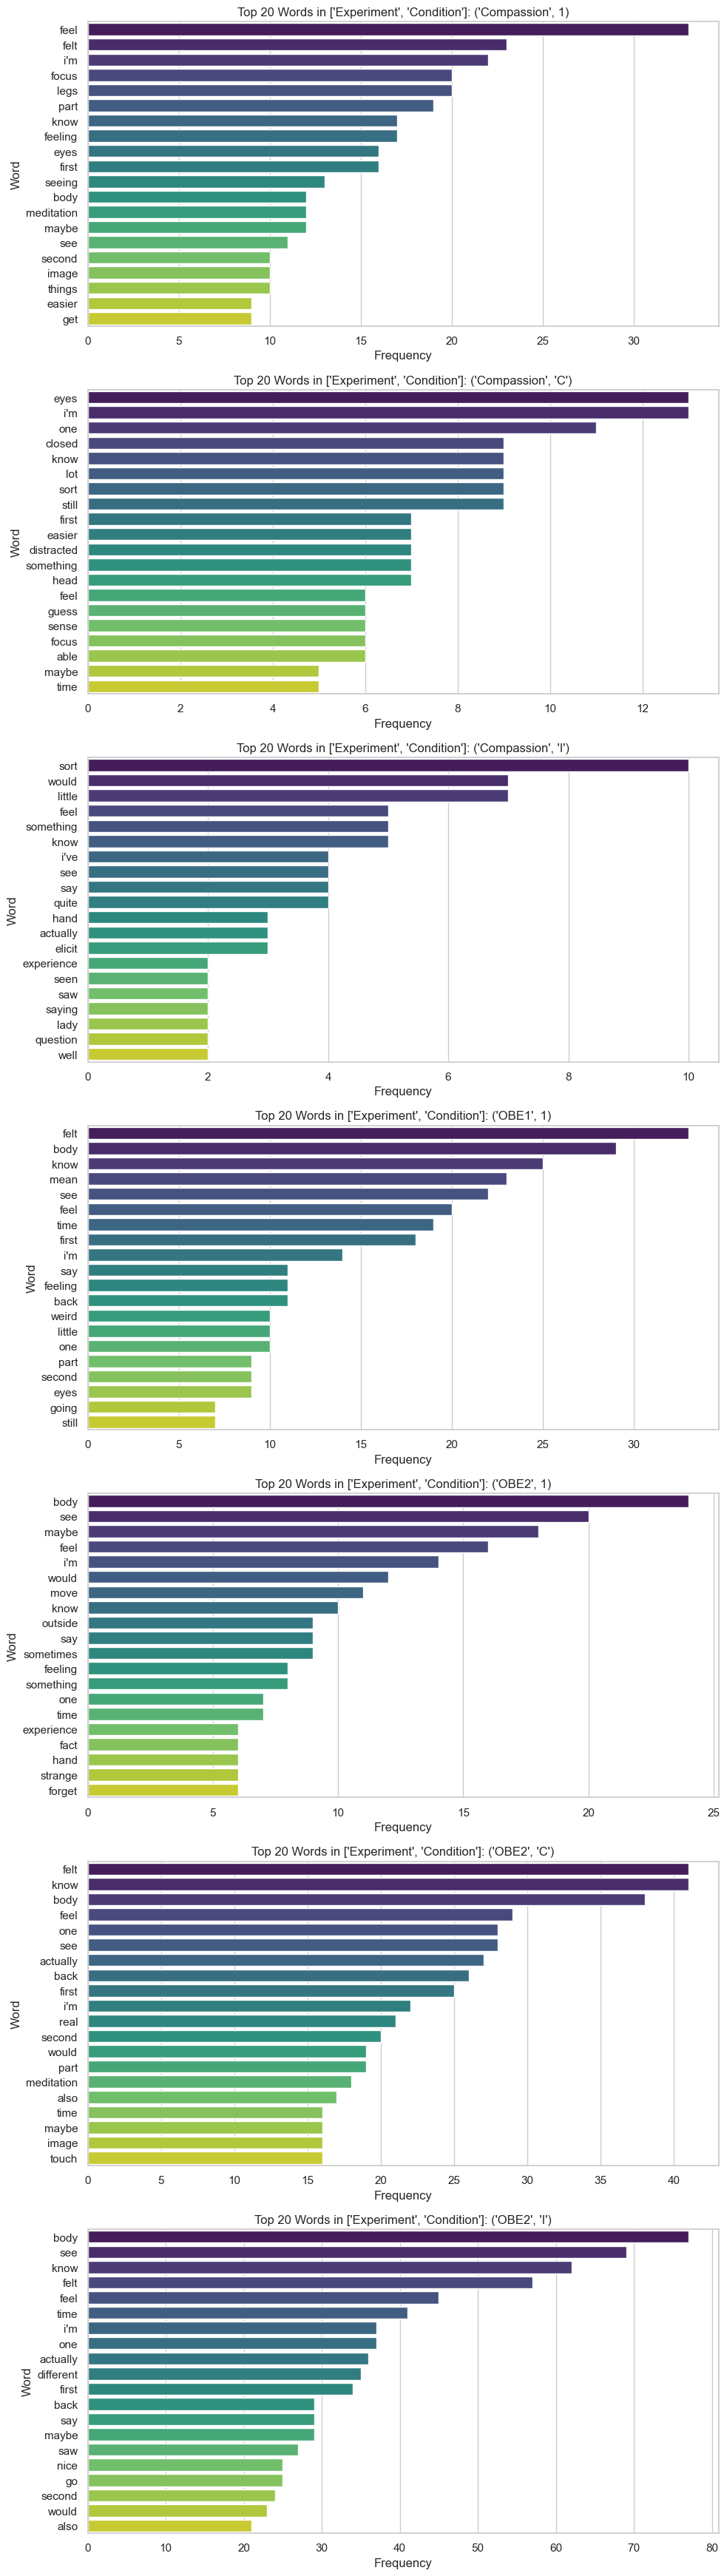

In [24]:
word_frequency_plot(combined_df_participant, groupby_column=["Experiment", "Condition"], extra_stopwords=extra_words_to_exclude)

In [ ]:
extra_words_to_exclude = ["yeah", "like","okay","really","it","yes","could","kind","bit","think","that's"] 
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df = count_unique_words(combined_df, groupby_columns=['Experiment', 'Condition'], omit_stop_words=True, extra_stopwords=extra_words_to_exclude)

unique_words_df = unique_words_df.sort_values(by='Participant_Count', ascending=False)
unique_words_df.to_csv("unique_words.csv", index=False)

In [ ]:
extra_words_to_exclude = ["yeah", "like","okay","really","it","yes","could","kind","bit","think","that's"] 
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(combined_df_participant, groupby_columns=['Experiment', 'Condition'], omit_stop_words=True, extra_stopwords=extra_words_to_exclude)

unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
unique_words_df_participant.to_csv("unique_words_participant.csv", index=False)

In [8]:
generate_word_clouds(unique_words_df_participant, groupby_columns=['Experiment'])

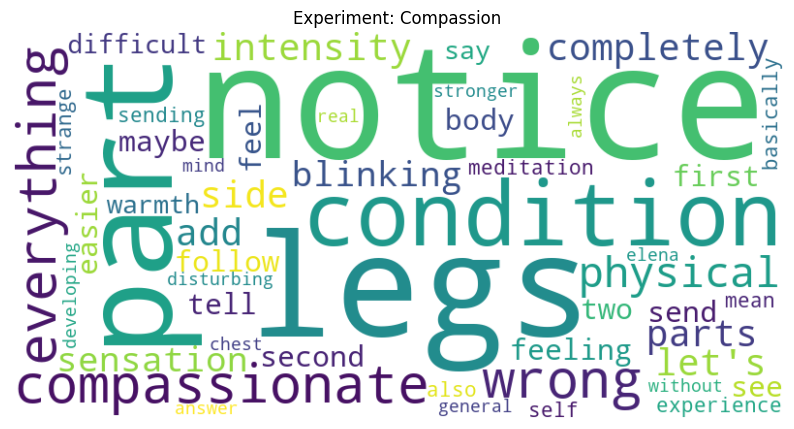

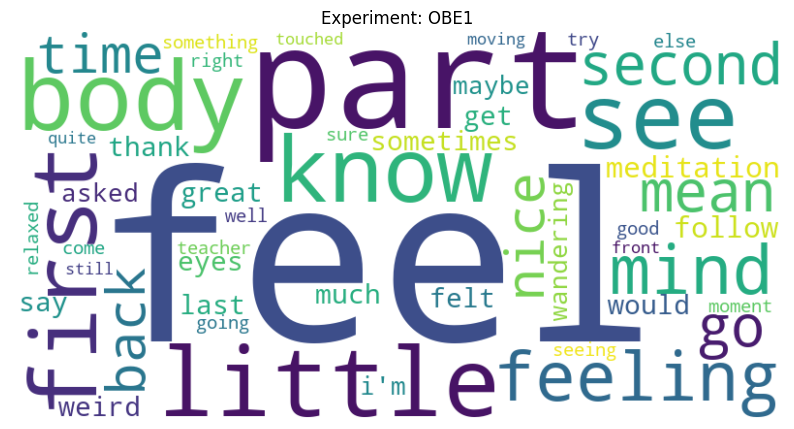

In [9]:
generate_word_clouds(unique_words_df, groupby_columns=['Experiment'])

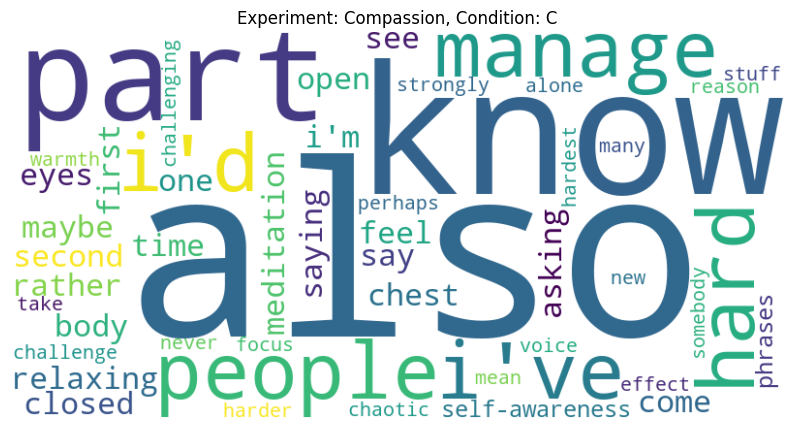

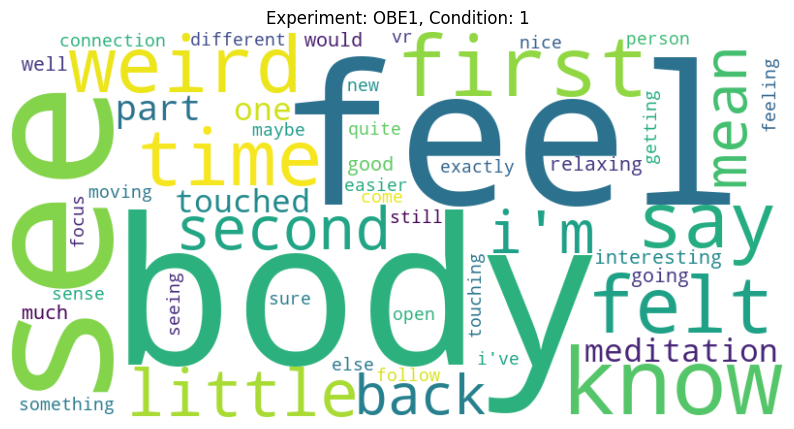

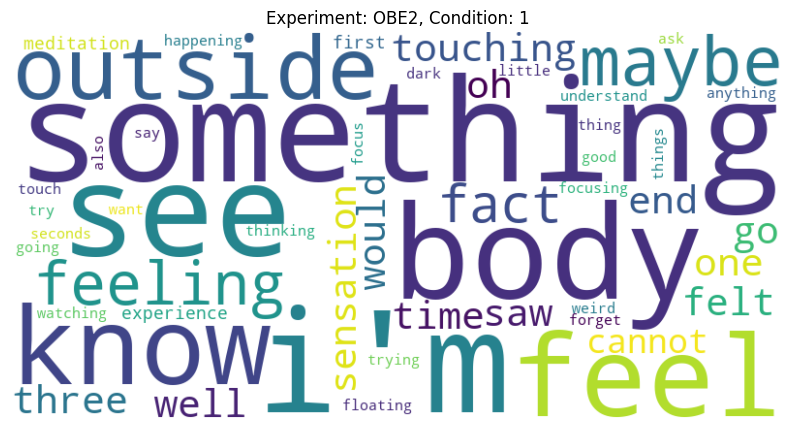

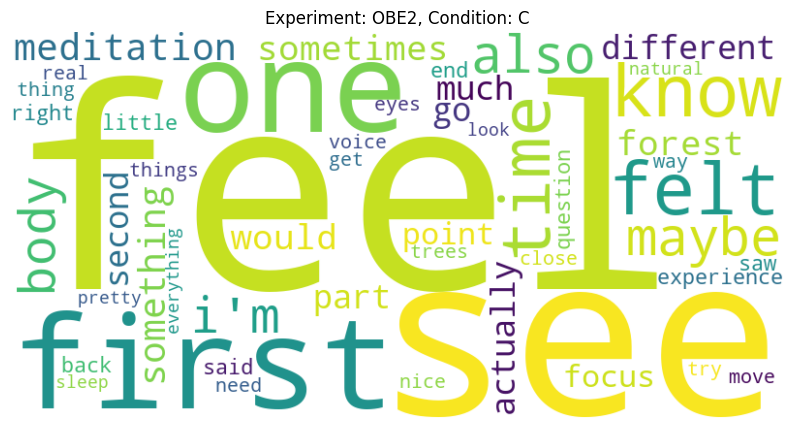

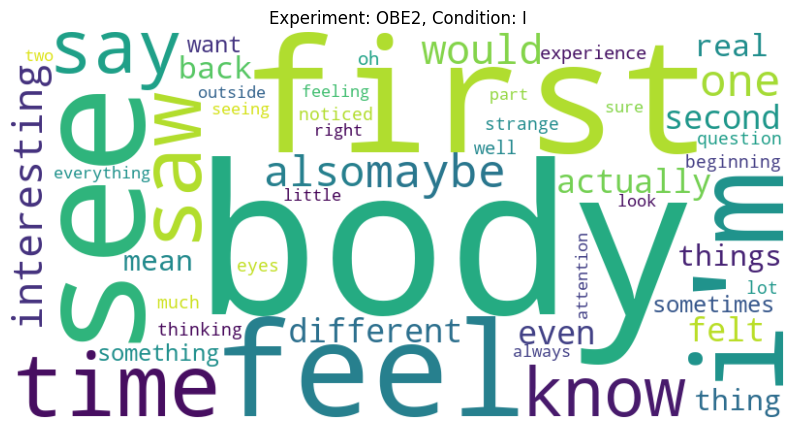

In [10]:
# Generate a word cloud for all data without filtering
generate_word_clouds(unique_words_df_participant, groupby_columns=['Experiment', 'Condition'])

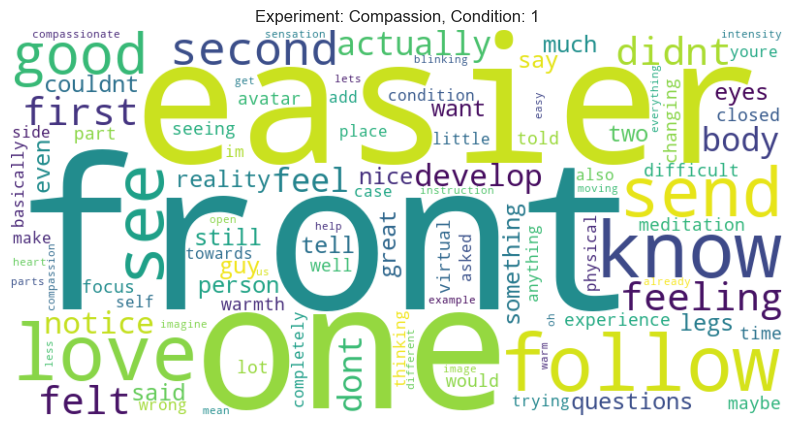

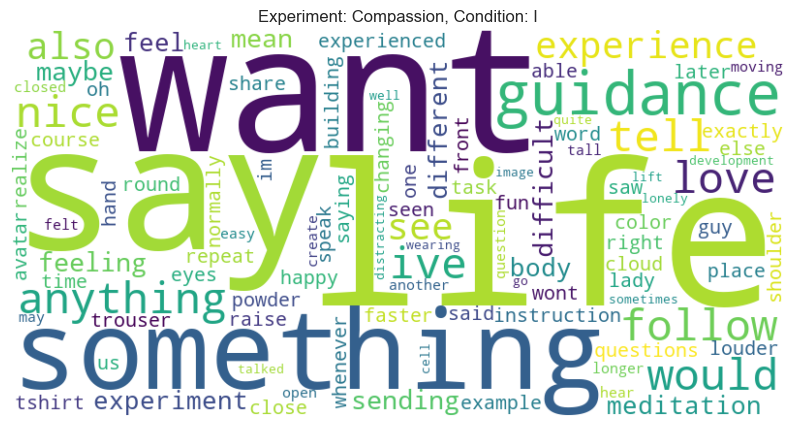

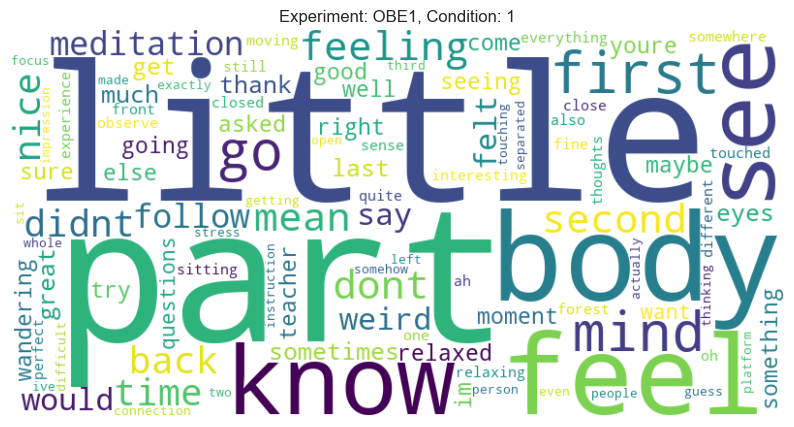

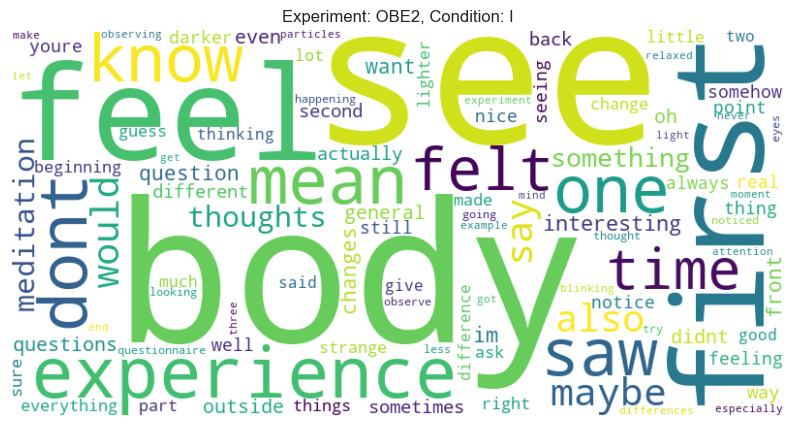

In [13]:
# Generate a word cloud for all data without filtering
generate_word_clouds(unique_words_df, groupby_columns=['Experiment', 'Condition'])